Using TensorFlow backend.


UMPM


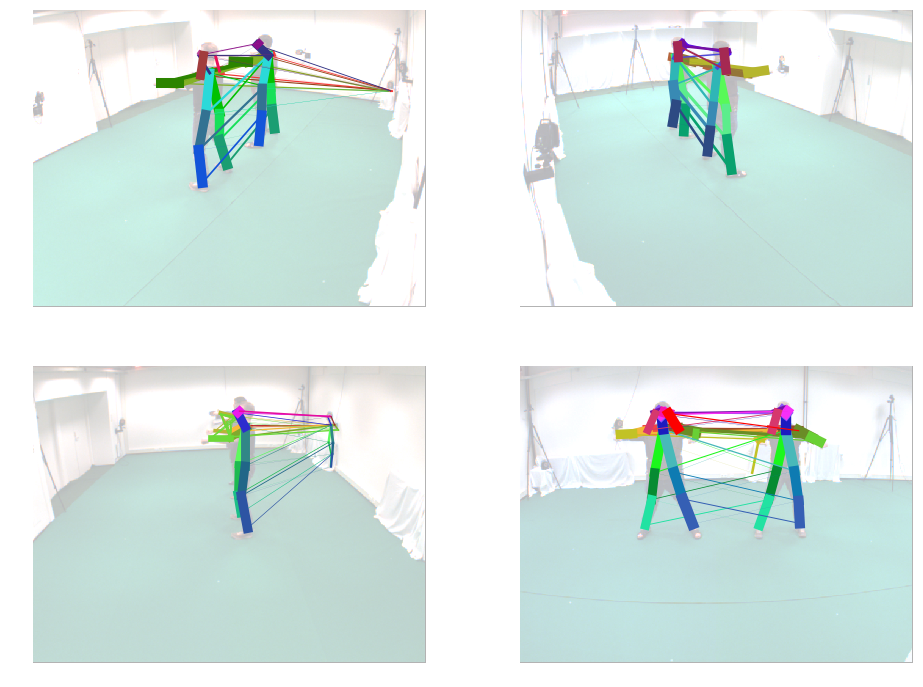

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
from mvpose.candidates import peaks as mvpeaks
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False



if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                _start = time()
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
                _end = time()
                print('elapsed:', _end - _start)
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []
Limb_Weights = []
Im_undist = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    im = Im[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    Limb_Weights.append(limbs)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    im_ud, K_new = gm.remove_distortion(im, cam)
    Im_undist.append(im_ud)
    h,w,_ = hm.shape
    mapx, mapy = \
        cv2.initUndistortRectifyMap(
            K, distCoef, None, K_new, (w, h), 5)
    peaks_undist = mvpeaks.Peaks.undistort(peaks, mapx, mapy)
    Peaks_undist.append(peaks_undist)
    
    assert peaks_undist.n_joints == peaks.n_joints
    for __k in range(peaks_undist.n_joints):
        p1 = peaks[__k]
        p2 = peaks_undist[__k]
        assert p1.shape == p2.shape, 'k:' + str(__k)
    
    Calib_undist.append({
        'K': K_new,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

2d:
	peaks1: (2, 3)
	peaks2: (2, 3)

3d:
	3d peaks: (4, 4)
elapsed 0.00861215591430664

n3d argmax:
	3d peaks: (2, 4)
	0 -> 0
	1 -> 1


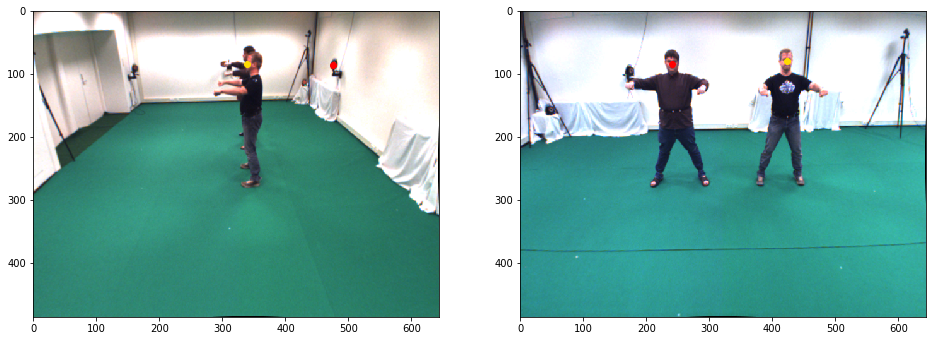

In [2]:
from cselect import color as cs

cam1 = 2; cam2 = 3
J = 0

K1, rvec1, tvec1, _ = gm.get_camera_parameters(Calib_undist[cam1])
peaks1 = Peaks_undist[cam1]
K2, rvec2, tvec2, _ = gm.get_camera_parameters(Calib_undist[cam2])
peaks2 = Peaks_undist[cam2]

print('2d:')
print('\tpeaks1:',peaks1[J].shape)
print('\tpeaks2:',peaks2[J].shape)

joints_3d, idx_pairs = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)

print('\n3d:')
print('\t3d peaks:', joints_3d[J].shape)


# ------------

_start = time()
pts3d, idx_pairs = stereo.triangulate_argmax(
    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
_end = time()
print('elapsed', _end - _start)

print('\nn3d argmax:')
print('\t3d peaks:', pts3d[J].shape)
for a,b in idx_pairs[J]:
    print('\t' + str(a) + ' -> ' + str(b))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot figure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121); ax.imshow(Im_undist[cam1])
ay = fig.add_subplot(122); ay.imshow(Im_undist[cam2])

COLOR1 = cs.lincolor(8)/255
COLOR2 = cs.lincolor(8)/255

for idx, (x,y,score) in enumerate(peaks1[J]):
    ax.scatter(x,y, color=COLOR1[idx])

for idx, (x,y,score) in enumerate(peaks2[J]):
    ay.scatter(x,y, color=COLOR2[idx])

In [29]:
A = np.zeros((0, 4))


a = np.expand_dims([1,2,3,4], axis=0)
b = np.expand_dims([4,5,6,7], axis=0)

A = np.append(A, a, axis=0)
A = np.append(A, b, axis=0)

print(A.shape)
print(A)

B = np.concatenate([A, A], axis=0)

print(B)

(2, 4)
[[1. 2. 3. 4.]
 [4. 5. 6. 7.]]
[[1. 2. 3. 4.]
 [4. 5. 6. 7.]
 [1. 2. 3. 4.]
 [4. 5. 6. 7.]]


In [58]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH
from mvpose.algorithm.meanshift import find_all_modes
import numpy.linalg as la

class Candidates:

    def __init__(self, peaks, limbs, Calib,
                 limbSeq=DEFAULT_LIMB_SEQ,
                 sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH):
        """
            triangulate all points in the cameras
        :param peaks: [{Peaks}]
        :param limbs: [{LimbWeights}]
        :param Calib: [{Camera}] The camera parameters MUST BE undistorted!
        :param limbSeq: {np.array[m x 2]} ids represent the joint (relative to the heatmaps)
        :param sensible_limb_length: {np.array[m x 2]} (low, high) of sensible limb length'
        :return: {Peaks3}, {LimbWeights3d}
        """
        n_cameras = len(Calib)
        n_joints = peaks[0].n_joints
        n_limbs = len(limbSeq)
        assert n_cameras == len(limbs)
        assert n_cameras == len(peaks)
        assert limbSeq.shape[1] == 2
        assert n_limbs == len(sensible_limb_length)
        
        POINTS_3d = [np.zeros((0, 4))] * n_joints  # per joint
        META = [np.zeros((0, 4), 'int32')] * n_joints  # per joint: [(cam1, cam2, idx1, idx2) ... ]
        # the meta data maps the points to their respective 2d camera pair
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 1: triangulate points
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        for cam1 in range(n_cameras - 1):
            K1, rvec1, tvec1, distCoef1 = \
                gm.get_camera_parameters(Calib[cam1])
            assert distCoef1 == 0
            peaks1 = peaks[cam1]
            
            for cam2 in range(cam1 + 1, n_cameras):
                K2, rvec2, tvec2, distCoef2 = \
                    gm.get_camera_parameters(Calib[cam2])
                assert distCoef2 == 0
                peaks2 = peaks[cam2]
                
                current_3d_peaks, idx_pairs = stereo.triangulate_argmax(
                    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
                assert len(current_3d_peaks) == n_joints
                
                for k in range(n_joints):
                    n = idx_pairs[k].shape[0]
                    pts3d = current_3d_peaks[k]
                    assert len(pts3d) == n
                    
                    POINTS_3d[k] = np.concatenate(
                        [POINTS_3d[k], pts3d])
                    
                    for i in range(n):
                        idx1 = idx_pairs[k][i,0]
                        idx2 = idx_pairs[k][i,1]
                        meta = np.expand_dims([cam1, idx1, cam2, idx2], axis=0)
                        META[k] = np.append(META[k], meta, axis=0)
        
        self.points3d = POINTS_3d
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 2: calculate weights
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        limbs3d = []
        for lid, (k1, k2) in enumerate(limbSeq):
            d_low, d_high = sensible_limb_length[lid]
            meta1 = META[k1]
            meta2 = META[k2]
            pts1 = POINTS_3d[k1]
            pts2 = POINTS_3d[k2]
            
            n = len(meta1)
            m = len(meta2)
            assert n == len(pts1)
            assert m == len(pts2)
            
            W = np.zeros((n, m))
            
            for u, (cam_a1, a1, cam_b1, b1) in enumerate(meta1):
                for v, (cam_a2, a2, cam_b2, b2) in enumerate(meta2):
                    assert cam_a1 != cam_b1 and cam_a2 != cam_b2
                    if cam_a1 == cam_a2 and cam_b1 == cam_b2:
                        p1_3d = pts1[u][0:3]
                        p2_3d = pts2[v][0:3]
                        W1 = limbs[cam_a1][lid]
                        W2 = limbs[cam_b1][lid]
                        distance = la.norm(p1_3d - p2_3d)
                    
                        if d_low < distance < d_high:
                            W[u,v] = W1[a1,a2] + W2[b1,b2]
            
            limbs3d.append(W)
        self.limbs3d = limbs3d
            
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 3: calculate weights
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
        
        
        
                

_start = time()
cand = Candidates(Peaks_undist, Limb_Weights, Calib_undist)
_end = time()
print('elapsed', _end - _start)

elapsed 0.04423069953918457
